ベイズ推論による機械学習第3章5節「線形回帰の例」を実装する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy
from tqdm import tqdm

sns.set_style('darkgrid')
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'IPAPGothic'

%matplotlib inline

3.5.1 モデルの構築

In [2]:
# 出力値: y(スカラー)
# 入力値: x(ベクトル)
# 重み: W(行列)
# モデル: y = W(転置)x + ε 
# εの確率分布: ε ~ N(ε|0, λ)
# モデルとεの確率分布を合体
# yの確率分布: y ~ N(y|W(転置)x, λ)
# 今回はWの確率分布を見たいので、Wについて事前分布を設定する
# Wの事前分布: W ~ N(W|M, Λ)
# ここでM, Λは超パラメータ(固定)

# 試しに、いくつかのWを取って、モデルがどのように変化するのか確かめる
# 3次元のグラフを考える
# Wの次元数を4にし、xを(1, x, x^2, x^3)とする

# まず適当にMとΛを設定してWをサンプリングする
m_vec = np.zeros(4)
lbd_w_mtx = np.eye(4)

w_vec = np.random.multivariate_normal(m_vec, lbd_w_mtx).reshape(4,1)

In [3]:
w_vec

array([[-0.26673898],
       [ 0.66363686],
       [-1.41028134],
       [ 0.50294251]])

In [4]:
# 次にx_vecをx=-10~10の範囲で連続的に取る
# 1行目から順に、1, x, x^2, x^3となるようにベクトルを組む
x = np.arange(-1, 1, 0.1).reshape(1,20) # 2次元arrayにする
x_mtx = np.ones((1, 20)) # 1行目

for i in range(3):
    x_mtx = np.append(x_mtx, x**(i+1), axis=0) # 2行目~4行目を追加

In [5]:
x_vec = x_mtx[:,1].reshape(4,1) # ベクトルxの例
x_vec

array([[ 1.   ],
       [-0.9  ],
       [ 0.81 ],
       [-0.729]])

In [6]:
# 最後に、yを求める
# 関数の形を知るのが目的なので、yに対してサンプリングは行わない
# まずは単一のx_vecで試す
y = np.dot(w_vec.T, x_vec)

In [7]:
# yは1*1ベクトルなので、スカラー(値)を取り出す必要がある
# np.asscalar(y)でもいいが、冗長なので以下のようにする
y.item()

-2.372985127601907

In [8]:
# ループ処理する
y_list = []
for i in range(x_mtx.shape[1]):
    x_vec = x_mtx[:,i].reshape(4,1)
    y = np.dot(w_vec.T, x_vec).item()
    y_list.append(y)

In [9]:
len(y_list)

20

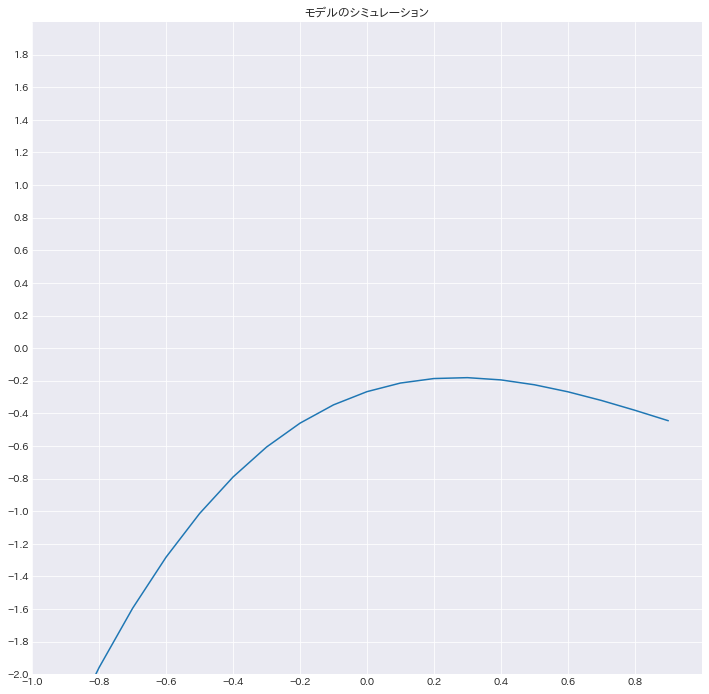

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.plot(x.reshape(20), y_list)
ax.set_xlim(-1, 1)
ax.set_ylim(-2, 2)
ax.set_xticks(np.arange(-1, 1, 0.2))
ax.set_yticks(np.arange(-2, 2, 0.2))
ax.set_title('モデルのシミュレーション')
plt.show()

描けた  
後は、Wを5つサンプリングして重ねて描画する

In [11]:
x.shape[1]

20

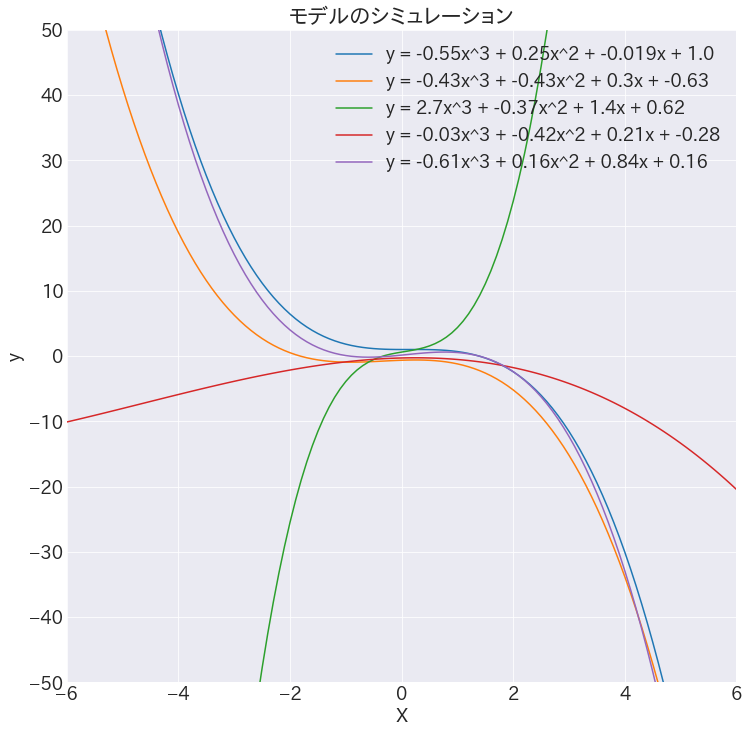

In [12]:
# 3次関数のグラフを考える
# Wの次元数を4にし、xを(1, x, x^2, x^3)とする
# まず適当にMとΛを設定してWをサンプリングする
n_draw = 5
dim = 4

# wをサンプリングするための準備
m_vec = np.zeros(dim)
matLMD_w = np.eye(dim)

# xの作成
x = np.arange(-6, 6.1, 0.1).reshape(1, 121)
matX = np.ones((1, x.shape[1]))
for i in range(1, dim):
    matX = np.append(matX, x**i, axis=0)
    
# wを任意の数サンプリングして、yを計算して、描画を重ねていく
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

# サンプリングしたwに対してループ
for w in np.random.multivariate_normal(m_vec, matLMD_w, n_draw):
    w_vec = w.reshape(4, 1)
    
    y_list = []
    for i in range(x.shape[1]):
        x_vec = matX[:, i].reshape(4, 1)
        y = (w_vec.T @ x_vec).item()
        y_list.append(y)
    
    ax.plot(x.reshape(121), y_list,
            label="y = {:.2}x^3 + {:.2}x^2 + {:.2}x + {:.2}".format(
                w_vec[3].item(), w_vec[2].item(), w_vec[1].item(), w_vec[0].item()))
    
# 図の体裁を整える
ax.set_xlim(-6, 6)
ax.set_ylim(-50, 50)
ax.set_xticks(np.arange(-6, 6.1, 2))
ax.set_yticks(np.arange(-50, 50.1, 10))
ax.set_title('モデルのシミュレーション')
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.legend()

# plt.savefig('../output/Chapter3/model_simulation.png')
plt.show()

次にサンプルのシミュレーションを作る  
任意の1つの三次関数に対して、Xを入力すると1次元正規分布からyがサンプリングされる様子を描く

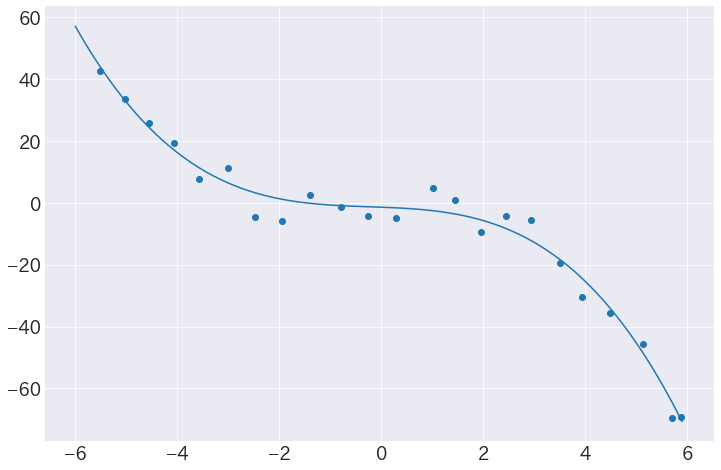

In [95]:
dim = 4
sigma = 20

# wをサンプリングするための超パラメータ
m_vec = np.zeros(dim)
matLMD_w = np.eye(dim)

# wを一つサンプリング
w_vec = np.random.multivariate_normal(m_vec, matLMD_w, 1)

# 関数描画用のxと、yをサンプリングするためのxを作る
x_func = np.arange(-6, 6, 0.1)
x_sampling = []
x_begin = -6
for i in np.random.normal(0.5, 0.1, 23):
    x_begin = x_begin + i
    x_sampling.append(x_begin)
x_sampling = np.array(x_sampling)
    
matX_func = np.ones((1, x_func.shape[0]))
for d in range(1, dim):
    matX_func = np.append(matX_func, (x_func ** d).reshape(1, matX_func.shape[1]), axis=0)
    
matX_sampling = np.ones((1, x_sampling.shape[0]))
for d in range(1, dim):
    matX_sampling = np.append(matX_sampling, (x_sampling ** d).reshape(1, matX_sampling.shape[1]), axis=0)
    
y_func = (w_vec @ matX_func).flatten()
    
# 3次関数を描画する
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x_func, y_func)

# x_sampling, w_vecからyをサンプリングして、重ねる
y_sampling = np.random.multivariate_normal((w_vec @ matX_sampling).flatten(), sigma * np.eye(23))
ax.scatter(x_sampling, y_sampling)

plt.show()

In [86]:
np.random.multivariate_normal((w_vec @ matX_sampling).flatten(), np.eye(23))

array([ 1.62408636e+02,  1.22439662e+02,  8.77092403e+01,  6.88556859e+01,
        4.79408119e+01,  3.28692702e+01,  1.82745142e+01,  1.05103376e+01,
        5.99066966e+00,  4.57264687e+00,  2.09645203e-01, -4.79312368e-01,
        2.36688634e+00, -1.44550425e-01,  3.72382799e-01, -1.13242024e+00,
       -3.82740434e+00, -8.33691764e+00, -1.50173995e+01, -3.09408894e+01,
       -4.69662607e+01, -6.20547191e+01, -9.87443893e+01])

In [64]:
for i in np.nditer(matX_sampling, flags=['external_loop'], order='F'):
    print(i)

[   1.           -5.55925993   30.90537096 -171.81099035]
[   1.           -5.00764154   25.0764738  -125.57399191]
[  1.          -4.21668535  17.78043532 -74.97450111]
[  1.          -3.7667946   14.18874159 -53.44607526]
[  1.          -3.2510574   10.56937421 -34.36164221]
[  1.          -2.70870882   7.33710346 -19.87407682]
[  1.          -2.34995425   5.52228498 -12.97711707]
[ 1.         -2.00457781  4.01833221 -8.05505961]
[ 1.         -1.54329545  2.38176084 -3.67576066]
[ 1.         -1.00370495  1.00742362 -1.01115607]
[ 1.         -0.66609289  0.44367974 -0.29553193]
[ 1.         -0.18381387  0.03378754 -0.00621062]
[1.00000000e+00 9.08011518e-02 8.24484916e-03 7.48641800e-04]
[1.         0.57614997 0.33194879 0.19125229]
[1.         1.0709883  1.14701595 1.22844067]
[1.         1.60847595 2.58719488 4.16144075]
[1.         2.08678323 4.35466425 9.08724034]
[ 1.          2.56379174  6.57302811 16.85187521]
[ 1.          3.0413982   9.25010298 28.13324651]
[ 1.          3.41